In [1]:
%load_ext autoreload
%autoreload 2

import generative_models as gm
import visualization as vis 
import dataset_utils

import torch
from torch import optim, nn
import pytorch_lightning as pl

import copy

# Preamble

In [2]:
# MNIST loader

LOADER = dataset_utils.create_loader(
    size=60000,
    batch_size=1000,
    digits=list(range(10))
    )

/home/juan/anaconda3/lib/python3.8/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448234945/work/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [3]:
# Model configuration
config = dict(
    hidden_dims = None,
    latent_dim = 2,
    ambient_dim = 784,
    act_fun = None,
    act_args = [],
    optimizer_class = optim.Adam,
    optimizer_kwargs = {"lr": 1e-3},
)

In [4]:
# Pytorch lightning training parameters

TRAINER_KWARGS = dict(
    max_epochs=100,
    checkpoint_callback=False,
    log_every_n_steps=1, 
    flush_logs_every_n_steps=len(LOADER),
    gpus=-1, # set to 0 if cpu use is prefered,
    auto_select_gpus=True
)


# Training

In [5]:
# Hyper-parameters for a sweep
hd_set = [[512,128,32],[128,32,8]]

act_fun_set = [nn.Tanh,nn.ReLU]
act_args_set = [None,None]

iterator = tuple((i, j) for i in hd_set for j in zip(act_fun_set,act_args_set))

In [7]:
for hd, (act_fun,act_args) in iterator:
  for model_class in [gm.VAE, gm.DAE, gm.GAN]:
    
    # Name 
    name = model_class.__name__ + "_" + str(hd) + "_" + act_fun.__name__

    # Copy and modify config
    CONFIG = copy.copy(config)
    CONFIG["hidden_dims"] = hd
    CONFIG["act_fun"] = act_fun

    # Train
    print("Training", name)
    model = model_class(**CONFIG)        
    trainer = pl.Trainer(**TRAINER_KWARGS)
    trainer.fit(model, train_dataloader=LOADER)
    
    # Save the model
    trainer.save_checkpoint("models/" + name)

Entrenando el modelo: VAE_[32, 8]_ReLU
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | encoder   | Sequential | 25.5 K
1 | mu_layer  | Linear     | 18    
2 | var_layer | Linear     | 18    
3 | decode    | Generator  | 26.3 K
-----------------------------------------
51.8 K    Trainable params
0         Non-trainable params
51.8 K    Total params
0.207     Total estimated model params size (MB)
Epoch 19: 100%|██████████| 60/60 [00:02<00:00, 26.74it/s, loss=-1e+07, v_num=28]
Entrenando el modelo: DAE_[32, 8]_ReLU
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name   | Type       | Params
--------------------------------------
0 | encode | Sequential | 25.5 K
1 | decode | Generator  | 26.3 K
--------------------------------------
51.7 K    Trainable params
0         N

# Results

/home/juan/Bureau/Git/DGM_interpolation/visualization.py:285: RuntimeWarning: invalid value encountered in log
  m[i] = np.log(np.transpose(J).mm(J).det()) # log determinant


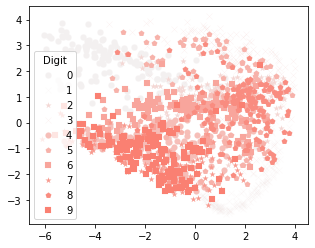

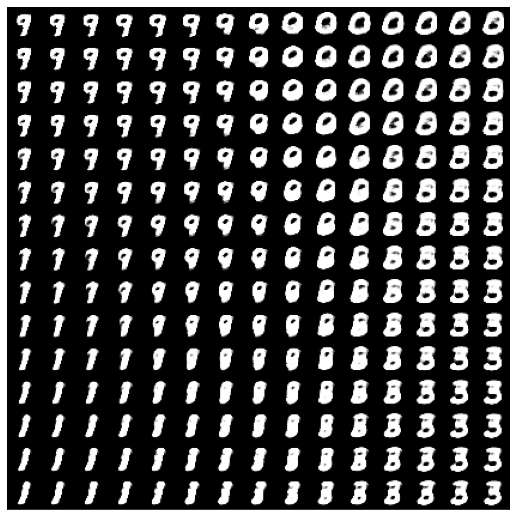

<Figure size 360x288 with 0 Axes>

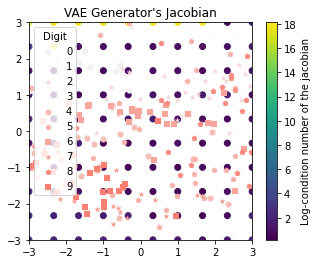

<Figure size 360x288 with 0 Axes>

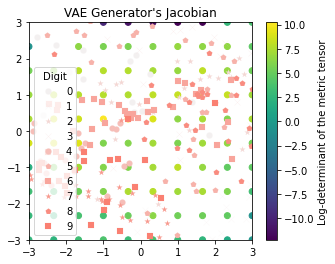

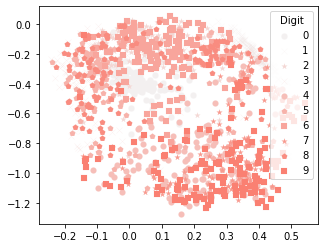

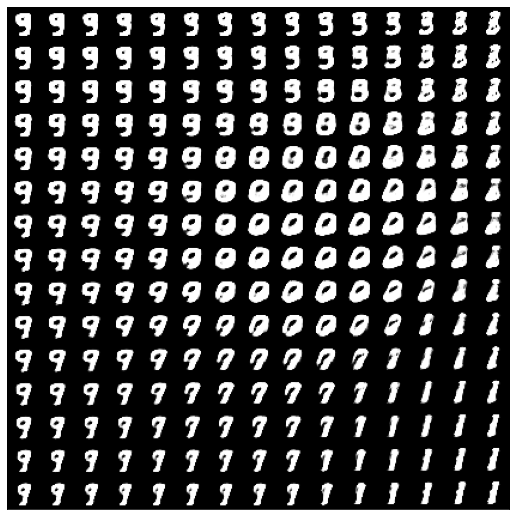

<Figure size 360x288 with 0 Axes>

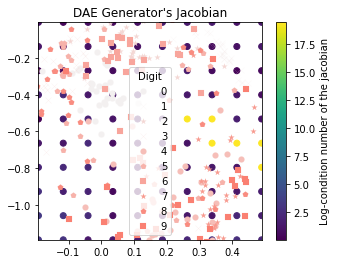

<Figure size 360x288 with 0 Axes>

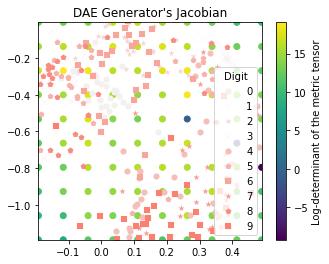

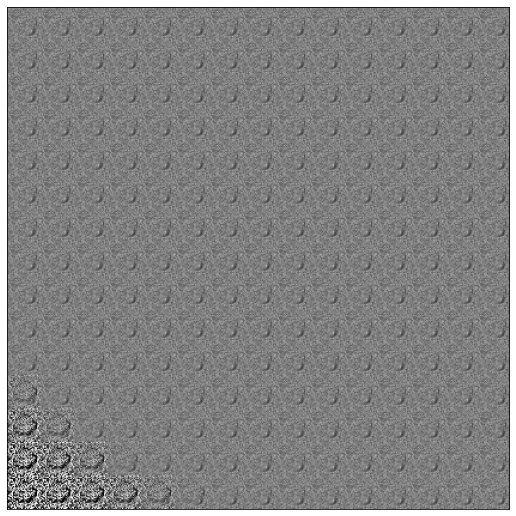

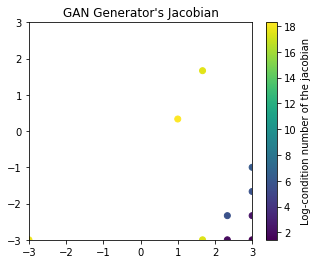

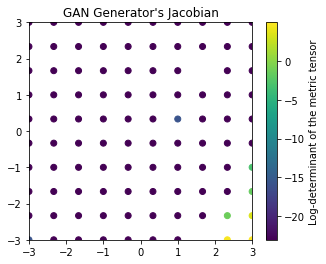

In [20]:
for hd, (act_fun,act_args) in iterator:
  for model_class in [gm.VAE, gm.DAE, gm.GAN]:

    # Name 
    name = model_class.__name__ + "_" + str(hd) + "_" + act_fun.__name__

    # Copy and modify config
    CONFIG = copy.copy(config)
    CONFIG["hidden_dims"] = hd
    CONFIG["act_fun"] = act_fun

    model = model_class.load_from_checkpoint(checkpoint_path="models/" + name, **CONFIG)
    model.eval()

    # Get the limits on the latent space
    if model_class.__name__ == "DAE":
      # The latent space is not regularized
      xmin,xmax,ymin,ymax = vis.manifold_limits(model, 1000)
    else: # VAE and DAE
      xmin,xmax,ymin,ymax = -3,3,-3,3 # From a normal distribution

    if model_class.__name__ != "GAN":
      # How the latent space looks like
      latent = vis.plot_latent_space(model, 1500, list(range(10)))
      latent.savefig("figs/" + name + "_latent.png")

    # Image Grid
    p = vis.plot_image_grid(model, 15, 15, xmin=xmin, xmax=xmax, ymin=ymin, ymax=ymax)
    p.savefig("figs/" + name + "_grid.png")

    # Jacobian
    p = vis.jac_plot(model, True, 300, 10, xmin, xmax, ymin, ymax) 
    p.savefig("figs/" + name + "_jacobian.png")

    # Magnitude
    p = vis.jac_plot(model, False, 300, 10, xmin, xmax, ymin, ymax) 
    p.savefig("figs/" + name + "_magnitude.png")  